In [2]:
%matplotlib inline

In [3]:
import tessrip

In [4]:
import lightkurve as lk
import matplotlib.pyplot as plt

/Users/nthom/opt/anaconda3/envs/py3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


The goal of this notebook is to explore the differences and similarities between a 'Rip' tpf and other TPF products. For some of this I am using lightkurve, but that is not necessary. However, as Rip stands, there are a few issues with reading ripped TPFs with lightkurve due to missing columns. For example, the time units are not in hdu1, so it assumes jd which is incorrect. 

# Get a SPOC TPF product

In [5]:
# Pick a classic target
sr = lk.search_targetpixelfile("Au Mic")
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,441420236,0.0
1,TESS Sector 27,2020,SPOC,20,441420236,0.0
2,TESS Sector 27,2020,SPOC,120,441420236,0.0
3,TESS Sector 01,2018,TESS-SPOC,1800,441420236,0.0
4,TESS Sector 27,2020,TESS-SPOC,600,441420236,0.0


In [6]:
# get all data regardless of quality
tpf = sr[4].download(quality_bitmask=None)
tpf.shape

(3360, 12, 11)

In [7]:
tpf.sector, tpf.camera, tpf.ccd

(27, 1, 3)

In [8]:
tpf.column, tpf.row, tpf.shape

(471, 1242, (3360, 12, 11))

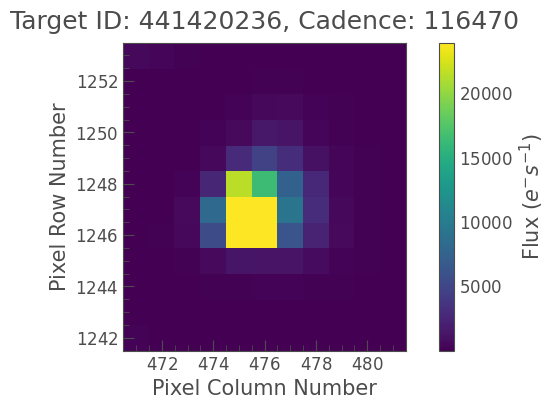

In [9]:
tpf.plot()
plt.show()

# Get a TESSrip at the same location

In [10]:
# Get location information from the TPF
rip = tessrip.Rip(tpf.sector, tpf.camera, tpf.ccd)
rip

In [11]:
# See what exists in the header before making the TPF. This comes from the AWS file. 
rip.primary_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
DATE    = '2020-09-25'         / file creation date.                            
TSTART  =    2036.283478026662 / observation start time in BTJD                 
TSTOP   =    2060.644819610229 / observation stop time in BTJD                  
DATE-OBS= '2020-07-05T18:47:03.318' / TSTART as UTC calendar date               
DATE-END= '2020-07-30T03:27:

In [12]:
# Now make the TPF
rip_ = rip.get_tpf(
        corner  = (tpf.row, tpf.column),
        shape = (tpf.shape[1], tpf.shape[2]),
        frame_range = None,
    )



In [13]:
# quality_bitmask required so ffi quality flags are not omitted. 
rip_tpf = lk.TessTargetPixelFile(rip_, quality_bitmask=None)

<Axes: title={'center': 'Target ID: None, Cadence: 1'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

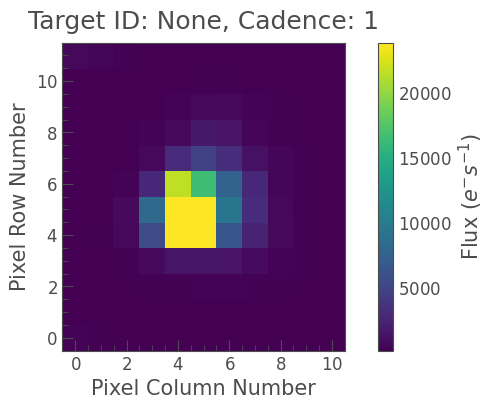

In [14]:
rip_tpf.plot()

In [15]:
# Do they match?
print(tpf.sector, tpf.camera, tpf.ccd)
print(rip_tpf.sector, rip_tpf.camera, rip_tpf.ccd)

27 1 3
27 1 3


In [16]:
# rip_tpf column/ row are not filled in, so something is different for this product.  
print(tpf.column, tpf.row, tpf.shape)
print(rip_tpf.column, rip_tpf.row, rip_tpf.shape)

471 1242 (3360, 12, 11)
0 0 (3360, 12, 11)


In [17]:
# Check out the difference between the SPOC header and TESSRIP
for key in tpf.get_header(ext=0).keys():
    if key not in rip_tpf.get_header(ext=0):
        #print(' ')
        print(f"{key} NOT IN TESSRIP")
        #print(' ')
    else:
        if tpf.get_header(ext=0)[key] != rip_tpf.get_header(ext=0)[key]:
            #print(f"{key} matches")
        #else:
            print(f"{key}: {tpf.get_header(ext=0)[key]} {rip_tpf.get_header(ext=0)[key]} ")

NEXTEND: 3 2 
ORIGIN: NASA/Ames STScI/MAST 
DATE: 2020-09-28 2020-09-25 
TSTART: 2036.28333644747 2036.283478026662 
TSTOP: 2060.644815473294 2060.644819610229 
DATE-OBS: 2020-07-05T18:46:51.085 2020-07-05T18:47:03.318 
DATE-END: 2020-07-30T03:27:22.873 2020-07-30T03:27:23.230 
CREATOR: 37157 TargetPixelExporterPipelineModule tessrip 
PROCVER: spoc-5.0.12-20200925 0.1.0dev 
OBJECT: TIC 441420236  
TICID: 441420236 None 
PXTABLE: -10000 0 
RA_OBJ NOT IN TESSRIP
DEC_OBJ NOT IN TESSRIP
PMRA: 281.424 0.0 
PMDEC: -359.895 0.0 
PMTOTAL: 456.8630854 0.0 
TESSMAG: 6.75500011 0.0 
TEFF: None 0.0 
LOGG: 4.57124996 0.0 
MH: None 0.0 
RADIUS: 0.69800901 0.0 
TICVER: 8.1 0 
CHECKSUM NOT IN TESSRIP


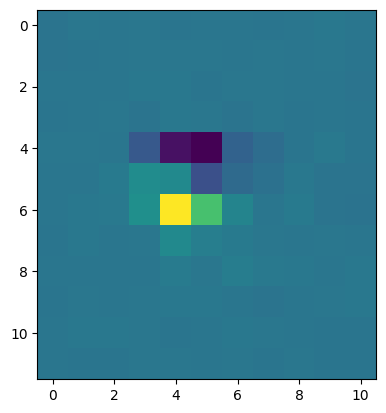

In [18]:
plt.imshow(tpf.flux[0,:,:].value - rip_tpf.flux[1,:,:].value)

# Time are in different units

We have a better understanding of this after talking with SPOC. The SPOC TPF products apply a barycentric correction based on CCD location. These just come from the FFI, which gives a single value for the center pixel (this is what TESSCut reports as well)

In [19]:
tpf.time[0:5]

<Time object: scale='tdb' format='btjd' value=[2036.28680866 2036.29375332 2036.30069798 2036.30764264 2036.3145873 ]>

In [20]:
rip_tpf.time[0:5]

<Time object: scale='tdb' format='jd' value=[2036.28695013 2036.29389475 2036.30083937 2036.30778399 2036.31472861]>

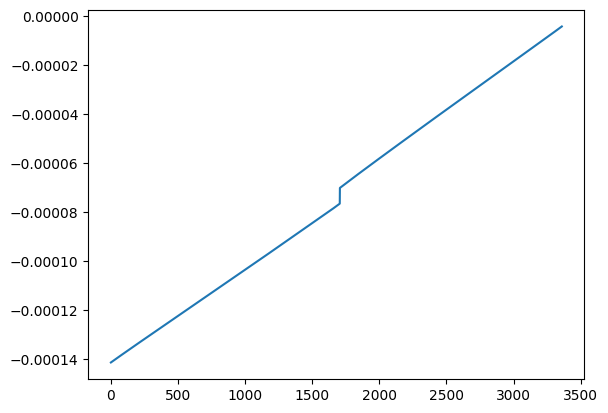

In [21]:
plt.plot(tpf.time.value-rip_tpf.time.value)

# Compare rip, tcut, tess-spoc, and spoc

In [22]:
import lksearch
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import tessrip
from astropy.io import fits


# get 4 sources for the same target
r = tessrip.Rip(sector=27, camera=1, ccd=3)
tessrip_hdulist = r.get_tpf((1242, 471), (12, 11))
spoc_hdulist = fits.open(lksearch.TESSSearch('Au Mic', pipeline='SPOC', sector=27, exptime=120).cubedata.download().loc[0, 'Local Path'])
tessspoc_hdulist = fits.open(lksearch.TESSSearch('Au Mic', pipeline='TESS-SPOC', sector=27).cubedata.download().loc[0, 'Local Path'])
tesscut_hdulist = fits.open('/Users/nthom/Downloads/tess-s0027-1-3_311.289719_-31.340899_11x12_astrocut.fits')




pipeline products: 100%|██████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


A little aside exploring the time. The time-related header keywords should be in hdu1. 

In [24]:
tessspoc_hdulist[1].data['time'], len(tessspoc_hdulist[1].data['time'])

(array([2036.28680866, 2036.29375332, 2036.30069798, ..., 2060.62745445,
        2060.6343989 , 2060.64134336], dtype='>f8'),
 3508)

In [25]:
spoc_hdulist[1].data['time'], len(spoc_hdulist[1].data['time'])

(array([2036.27847507, 2036.279864  , 2036.28125293, ..., 2060.64412114,
        2060.64551004, 2060.64689893], dtype='>f8'),
 17546)

In [26]:
tesscut_hdulist[1].data['time'], len(tesscut_hdulist[1].data['time'])

(array([2036.28695013, 2036.29389475, 2036.30083937, ..., 2060.62745867,
        2060.63440309, 2060.64134751], dtype='>f8'),
 3360)

In [27]:
tessrip_hdulist[1].data['time'], len(tessrip_hdulist[1].data['time'])

(array([2036.28695013, 2036.29389475, 2036.30083937, ..., 2060.62745867,
        2060.63440309, 2060.64134751]),
 3360)

In [28]:
tessspoc_hdulist[1].header['TIMESYS'], spoc_hdulist[1].header['TIMESYS'], tesscut_hdulist[0].header['TIMESYS'], tessrip_hdulist[0].header['TIMESYS']

('TDB', 'TDB', 'TDB', 'TDB')

In [29]:
tessspoc_hdulist[1].header['TASSIGN'], spoc_hdulist[1].header['TASSIGN'], tesscut_hdulist[0].header['TASSIGN'], tessrip_hdulist[0].header['TASSIGN']

('SPACECRAFT', 'SPACECRAFT', 'SPACECRAFT', 'SPACECRAFT')

In [30]:
tessspoc_hdulist[1].header['TIMEREF'], spoc_hdulist[1].header['TIMEREF'], tesscut_hdulist[1].header['TIMEREF'], tessrip_hdulist[0].header['TIMEREF']

('SOLARSYSTEM', 'SOLARSYSTEM', 'SOLARSYSTEM', 'SOLARSYSTEM')

In [31]:
tessspoc_hdulist[1].header['BJDREFF'], spoc_hdulist[1].header['BJDREFF'], tesscut_hdulist[1].header['BJDREFF'], tessrip_hdulist[0].header['BJDREFF']

(0.0, 0.0, 0.0, 0.0)

In [32]:
tessspoc_hdulist[1].header['BJDREFI'], spoc_hdulist[1].header['BJDREFI'], tesscut_hdulist[0].header['BJDREFI'], tessrip_hdulist[0].header['BJDREFI']

(2457000, 2457000, 2457000, 2457000)

In [33]:
tesscut_hdulist[1].header['TIMEREF'], tesscut_hdulist[0].header['TIMEREF']

('SOLARSYSTEM', 'SOLARSYSTEM')

In [34]:
tessrip_hdulist[0].header['TIMESYS']

'TDB'

In [35]:
# what's the difference between tesscut and tessrip?
for key in tesscut_hdulist[0].header.keys():
    if key not in tessrip_hdulist[0].header.keys():
        print(key)

RA_OBJ
DEC_OBJ
CHECKSUM
DATASUM


In [36]:
# Compare TESS-SPOC with TESSrip
for key in tessspoc_hdulist[2].header.keys():
    if key not in tessrip_hdulist[2].header.keys():
        print(f"{key}: {tessspoc_hdulist[2].header[key]}")

INHERIT: True
EXTVER: 1
SIMDATA: False
TELESCOP: TESS
INSTRUME: TESS Photometer
OBJECT: TIC 441420236
TICID: 441420236
RA_OBJ: 311.29159849294916
DEC_OBJ: -31.3409004606736
EQUINOX: 2000.0
WCSNAMEP: PHYSICAL
WCSAXESP: 2
CTYPE1P: RAWX
CUNIT1P: PIXEL
CRPIX1P: 1
CRVAL1P: 471
CDELT1P: 1.0
CTYPE2P: RAWY
CUNIT2P: PIXEL
CRPIX2P: 1
CRVAL2P: 1242
CDELT2P: 1.0
CHECKSUM: hAAOj52LhA8Lh38L


In [37]:
# Clearly some background subtraction happened. 
tessrip_hdulist[1].data['flux'][0,:,:] - tessspoc_hdulist[1].data['flux'][0,:,:]


array([[150.19673, 150.19673, 150.19672, 150.19672, 150.19672, 150.19673,
        150.19673, 150.19672, 150.19673, 150.19673, 150.19672],
       [150.19673, 150.19673, 150.19673, 150.19672, 150.19672, 150.19673,
        150.19672, 150.19673, 150.19673, 150.19673, 150.19672],
       [150.19673, 150.19672, 150.19672, 150.19672, 150.19673, 150.19673,
        150.19672, 150.19673, 150.19673, 150.19673, 150.19673],
       [150.19672, 150.19673, 150.19672, 150.19672, 150.19666, 150.19666,
        150.19666, 150.19672, 150.19672, 150.19672, 150.19672],
       [150.19673, 150.19673, 150.19672, 150.19678, 150.19531, 150.19531,
        150.19678, 150.19653, 150.19672, 150.19673, 150.19673],
       [150.19673, 150.19673, 150.19672, 150.19629, 150.19531, 150.19922,
        150.19629, 150.19653, 150.19672, 150.19672, 150.19672],
       [150.19672, 150.19672, 150.19672, 150.19678, 150.19727, 150.19629,
        150.19678, 150.19678, 150.19672, 150.19673, 150.19672],
       [150.19673, 150.19673, 150.

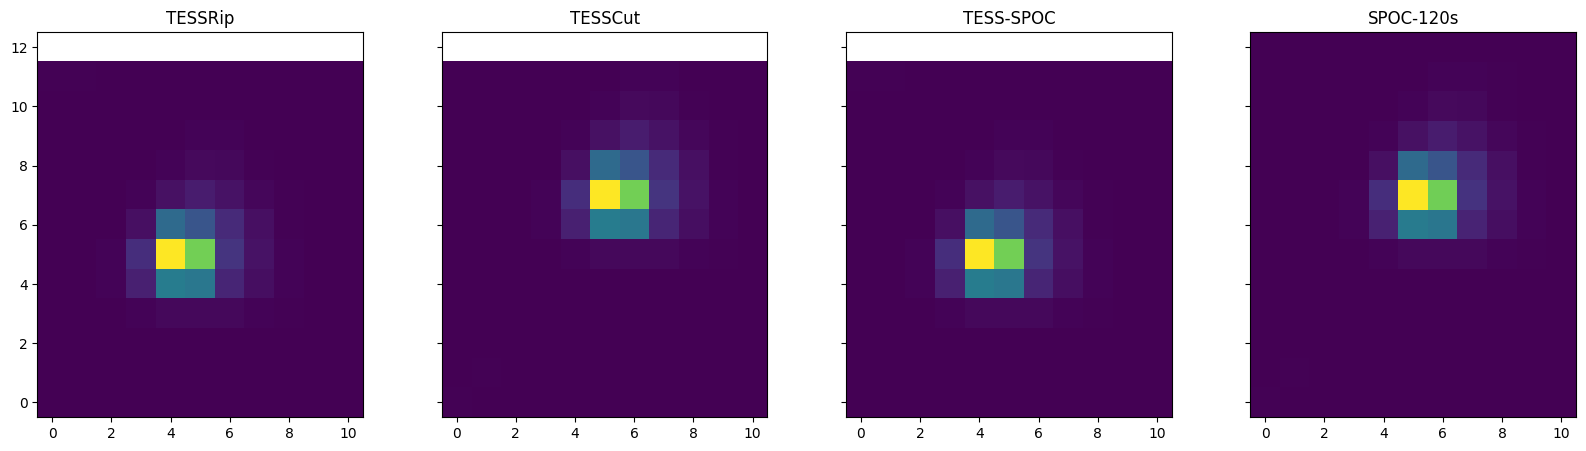

In [38]:
fix, ax = plt.subplots(1,4, figsize=(20,5), sharex=True, sharey=True)

ax[0].imshow(tessrip_hdulist[1].data['flux'][0,:,:], origin='lower')
ax[1].imshow(tesscut_hdulist[1].data['flux'][0,:,:], origin='lower')
ax[2].imshow(tessspoc_hdulist[1].data['flux'][0,:,:], origin='lower')
ax[3].imshow(spoc_hdulist[1].data['flux'][0,:,:], origin='lower')
ax[0].set_title('TESSRip')
ax[1].set_title('TESSCut')
ax[2].set_title('TESS-SPOC')
ax[3].set_title('SPOC-120s')
plt.show()


In [39]:
rip_tpf.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 307.18557603347  -30.912325770178  
CRPIX : 1045.0  1001.0  
PC1_1 PC1_2  : -0.0055063073182245  0.0016384645831805  
PC2_1 PC2_2  : -0.001498927864551  -0.005467870053748  
CDELT : 1.0  1.0  
NAXIS : 11  12

# WCS

In [40]:
from astropy.wcs import WCS

In [41]:
WCS(tessrip_hdulist[2].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 307.18557603347  -30.912325770178  
CRPIX : 1045.0  1001.0  
PC1_1 PC1_2  : -0.0055063073182245  0.0016384645831805  
PC2_1 PC2_2  : -0.001498927864551  -0.005467870053748  
CDELT : 1.0  1.0  
NAXIS : 11  12

In [42]:
WCS(tesscut_hdulist[2].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 311.29174672107  -31.33459506561  
CRPIX : 6.0020600461059  6.5016990238622  
PC1_1 PC1_2  : -0.005305950885286  0.0018700734582767  
PC2_1 PC2_2  : -0.001668832862637  -0.0053717728568193  
CDELT : 1.0  1.0  
NAXIS : 11  12

In [43]:
WCS(tessspoc_hdulist[2].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 311.29159849294916  -31.342954196299843  
CRPIX : 5.499183574572896  5.87883437013852  
PC1_1 PC1_2  : 0.9435852380957286  -0.3325842182626787  
PC2_1 PC2_2  : -0.29680214116207493  -0.9551742179878026  
CDELT : -0.005623552173782  0.005623552173781546  
NAXIS : 11  12

In [44]:
WCS(spoc_hdulist[2].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 311.2915984926011  -31.3429541959197  
CRPIX : 6.493976841082485  7.87889574139831  
PC1_1 PC1_2  : 0.9435869598199019  -0.3325527787942244  
PC2_1 PC2_2  : -0.29676672877629146  -0.955194844854364  
CDELT : -0.005623600701894  0.005623600701893735  
NAXIS : 11  13